# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Video based Action Classification using LSTM

## Learning Objectives

At the end of the experiment, you will be able to :

* extract frames out of a video
* build the CNN model to extract features from the video frames
* train LSTM/GRU model to perform action classification

## Information

**Background:** The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Specifically, the problems of:



*   Activity Recognition: Generating a textual description of an activity demonstrated in a sequence of images
*   Image Description: Generating a textual description of a single image.
*   Video Description: Generating a textual description of a sequence of images.

**Applications:** Applications such as surveillance, video retrieval and
human-computer interaction require methods for recognizing human actions in various scenarios. In the area of robotics, the tasks of
autonomous navigation or social interaction could also take advantage of the knowledge extracted
from live video recordings. Typical scenarios
include scenes with cluttered, moving backgrounds, nonstationary camera, scale variations, individual variations in
appearance and cloth of people, changes in light and view
point and so forth. All of these conditions introduce challenging problems that can be addressed using deep learning (computer vision) models.

## Dataset



**Dataset:** This dataset consists of labelled videos of 6 human actions (walking, jogging, running, boxing, hand waving and hand clapping) performed several times by 25 subjects in four different scenarios: outdoors s1, outdoors with scale variation s2, outdoors with different clothes s3 and indoors s4 as illustrated below.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/actions.gif)

All sequences were taken over homogeneous backgrounds with a static camera with 25fps frame rate. The sequences were downsampled to the spatial resolution of 160x120 pixels and have a length of four seconds in average. In summary, there are 25x6x4=600 video files for each combination of 25 subjects, 6 actions and 4 scenarios. For this mini-project we have randomly selected 20% of the data as test set.

Dataset source: https://www.csc.kth.se/cvap/actions/

**Methodology:**

When performing image classification, we input an image to our CNN; Obtain the predictions from the CNN;
Choose the label with the largest corresponding probability


Since a video is just a series of image frames, in a video classification, we Loop over all frames in the video file;
For each frame, pass the frame through the CNN; Classify each frame individually and independently of each other; Choose the label with the largest corresponding probability;
Label the frame and write the output frame to disk

Refer this [Video Classification using Keras](https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77) for complete understanding and implementation example of video classification.

## Problem Statement

Train a CNN-LSTM based deep neural net to recognize the action being performed in a video

## Grading = 10 Points

### Install and re-start the runtime

In [1]:
# !pip3 install imageio==2.4.1


In [2]:
# @title Download Dataset
# !wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
# !unzip -qq Actions.zip
# print("Dataset downloaded successfully!!")


from utility import download_and_unzip

download_and_unzip(
    filename="Actions.zip",
    url="https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip",
)


--2025-05-17 11:12:39--  https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1152805438 (1.1G) [application/zip]
Saving to: ‘Actions.zip’

     0K .......... .......... .......... .......... ..........  0% 1016K 18m28s
    50K .......... .......... .......... .......... ..........  0% 2.95M 12m20s
   100K .......... .......... .......... .......... ..........  0% 2.36M 10m49s
   150K .......... .......... .......... .......... ..........  0% 4.21M 9m12s
   200K .......... .......... .......... .......... ..........  0% 34.4M 7m28s
   250K .......... .......... .......... .......... ..........  0% 2.51M 7m26s
   300K .......... .......... .......... .......... ..........  0% 3.32M 7m10s
   350K .......... .......... .......... .......... ...

True

### Import required packages

In [3]:
import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import *
from tensorflow.keras.utils import to_categorical

# from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import (
    GlobalAveragePooling2D,
    LSTM,
    TimeDistributed,
    GRU,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    MaxPool2D,
    GlobalMaxPool2D,
    Dense,
    Input,
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split

import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
# Verify GPU availability
# import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))


Num GPUs Available:  0


### Load the data and generate frames of video (2 points)

Detecting an action is possible by analyzing a series of images (that we name “frames”) that are taken in time.

Hint: Refer data preparation section in [keras_video_classification](https://keras.io/examples/vision/video_classification/)


In [4]:
# data_dir = "/content/Actions/train/"
# test_data_dir = "/content/Actions/test/"
# YOUR CODE HERE
# data_dir = "Actions_temp/train/"
# test_data_dir = "Actions_temp/test/"

data_dir = "Actions/train/"
test_data_dir = "Actions/test/"


In [5]:
def play_video(video_path):
    cap = cv.VideoCapture(video_path)

    while cap.isOpened():
        ret, frame = cap.read()

        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        cv.imshow("frame", gray)
        if cv.waitKey(25) == ord("q"):
            break

    cap.release()
    cv.destroyAllWindows()


# play_video(data_dir + "boxing/person01_boxing_d1_uncomp.avi")


In [6]:
# def load_video_into_array_(file_path):
#     # Load the video from the file path
#     cap = cv.VideoCapture(file_path)

#     # Initialize an empty list to store the frames
#     frames = []

#     # Loop through the video frames
#     while cap.isOpened():
#         # Read the frame
#         ret, frame = cap.read()

#         # If the frame was not read correctly, break the loop
#         if not ret:
#             break

#         # Convert the frame to grayscale
#         frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

#         # Resize the frame to 224x224
#         frame = cv.resize(frame, (224, 224))

#         # Normalize the pixel values
#         frame = frame / 255.0

#         # Append the frame to the frames list
#         frames.append(frame)

#     # Release the VideoCapture object and close the window
#     cap.release()
#     cv.destroyAllWindows()

#     # Convert the frames list to a numpy array
#     frames = np.array(frames)

#     return frames




In [7]:
def load_video_into_dataframe(root_path):
    # Initialize an empty list to store the file names and labels
    data = []

    # Loop through each subfolder in the folder
    for subfolder in os.listdir(root_path):
        subfolder_path = os.path.join(root_path, subfolder)
        if os.path.isdir(subfolder_path):
            # Loop through each file in the subfolder
            for file_name in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file_name)
                if os.path.isfile(file_path):
                    # Append the file name and label (subfolder name) to the data list
                    data.append(
                        {
                            "folder": subfolder_path,
                            "file_name": file_name,
                            "label": subfolder,
                        }
                    )

    # Create a dataframe from the data list
    df = pd.DataFrame(data)

    return df


In [8]:
df_data = pd.DataFrame()
df_data = load_video_into_dataframe(data_dir)
df_data.head(5)


,folder,file_name,label
0,Actions/train/running,person11_running_d1_uncomp.avi,running
1,Actions/train/running,person21_running_d4_uncomp.avi,running
2,Actions/train/running,person07_running_d1_uncomp.avi,running
3,Actions/train/running,person08_running_d2_uncomp.avi,running
4,Actions/train/running,person15_running_d3_uncomp.avi,running


In [9]:
df_data.groupby("label").count()


,folder,file_name
label,,
Handclapping,79,79
Walking,80,80
boxing,80,80
handwaving,80,80
jogging,80,80
running,80,80


In [10]:
df_test_data = pd.DataFrame()
df_test_data = load_video_into_dataframe(test_data_dir)
df_test_data.head(5)


,folder,file_name,label
0,Actions/test/running,person16_running_d2_uncomp.avi,running
1,Actions/test/running,person19_running_d1_uncomp.avi,running
2,Actions/test/running,person13_running_d1_uncomp.avi,running
3,Actions/test/running,person02_running_d2_uncomp.avi,running
4,Actions/test/running,person05_running_d1_uncomp.avi,running


In [11]:
df_test_data.groupby("label").count()


,folder,file_name
label,,
Handclapping,20,20
Walking,20,20
boxing,20,20
handwaving,20,20
jogging,20,20
running,20,20


In [12]:
def create_preprocess_folder(name_preprocessed_folder, org_root_dir, datatype_dir):
    datatype_dir_path = os.path.join(name_preprocessed_folder, datatype_dir)
    if not os.path.exists(datatype_dir_path):
        os.makedirs(datatype_dir_path)

    # Loop through each subfolder in the data directory
    for subfolder in os.listdir(org_root_dir):
        class_dir_path = os.path.join(datatype_dir_path, subfolder)
        if not os.path.exists(class_dir_path):
            os.makedirs(class_dir_path)


In [13]:
create_preprocess_folder("preprocessed_videos", data_dir, "train")
create_preprocess_folder("preprocessed_videos", test_data_dir, "test")


In [14]:
summary_frame_data = []
MAX_FRAMES = 20


In [15]:
def extract_frames_from_avi(
    video_path, output_folder, frame_prefix="frame_", file_format=".jpg"
):
    try:
        # Check if video file exists
        if not os.path.isfile(video_path):
            print(f"Error: Video file '{video_path}' does not exist.")
            return -1

        # Create output folder if it doesn't exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
            print(f"Created output directory: {output_folder}")

        # Initialize video capture
        cap = cv.VideoCapture(video_path)

        # Check if video opened successfully
        if not cap.isOpened():
            print(f"Error: Could not open video file '{video_path}'.")
            return -1

        # Get video properties
        fps = cap.get(cv.CAP_PROP_FPS)
        frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
        duration = frame_count / fps if fps > 0 else 0
        frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
        frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
        ret, frame = cap.read()
        channels = frame.shape[2] if ret else None

        # Reset to beginning of video
        cap.set(cv.CAP_PROP_POS_FRAMES, 0)

        # Extract frames
        frame_number = 0
        frames_saved = 0

        while True:
            # Read next frame
            success, frame = cap.read()

            # Break the loop if we've reached the end of the video
            if not success or frame is None or frame_number >= MAX_FRAMES:
                break

            # Construct output filename with leading zeros for proper sorting
            frame_filename = f"{frame_prefix}{frame_number:06d}{file_format}"
            output_path = os.path.join(output_folder, frame_filename)

            # Save the frame
            cv.imwrite(output_path, frame)
            frames_saved += 1

            # Increment frame counter
            frame_number += 1

    except Exception as e:
        print(f"Error: {e}")
    finally:
        # Release the video capture object
        cap.release()

    print(f"Extraction complete. Saved {frames_saved} frames to {output_folder}")

    summary_frame_data.append(
        {
            "video_path": video_path,
            "fps": fps,
            "frame_count": frame_count,
            "duration": duration,
            "frame_height": frame_height,
            "frame_width": frame_width,
            "channels": channels,
            "frames_saved": frames_saved,
        }
    )


In [16]:
df_data.head(5)


,folder,file_name,label
0,Actions/train/running,person11_running_d1_uncomp.avi,running
1,Actions/train/running,person21_running_d4_uncomp.avi,running
2,Actions/train/running,person07_running_d1_uncomp.avi,running
3,Actions/train/running,person08_running_d2_uncomp.avi,running
4,Actions/train/running,person15_running_d3_uncomp.avi,running


In [17]:
def extract_frames_from_videos(df, preprocessed_folder):
    # Loop through each row in the dataframe
    for index, row in df.iterrows():
        # Get the file path
        file_path = os.path.join(row["folder"], row["file_name"])

        # Get the label
        label = row["label"]

        # Create a folder for the label if it doesn't exist
        label_folder = os.path.join(
            os.path.join(preprocessed_folder, label), row["file_name"].split(".")[0]
        )
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)

        # Extract frames from the video
        extract_frames_from_avi(video_path=file_path, output_folder=label_folder)


In [18]:
extract_frames_from_videos(df_data, "preprocessed_videos/train")


Extraction complete. Saved 20 frames to preprocessed_videos/train/running/person11_running_d1_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/train/running/person21_running_d4_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/train/running/person07_running_d1_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/train/running/person08_running_d2_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/train/running/person15_running_d3_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/train/running/person05_running_d4_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/train/running/person13_running_d4_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/train/running/person03_running_d3_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/train/running/person24_running_d2_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/train/running/person23_running_

In [19]:
summary_frame_data_df = pd.DataFrame(summary_frame_data)
summary_frame_data_df.head(5)


,video_path,fps,frame_count,duration,frame_height,frame_width,channels,frames_saved
0,Actions/train/running/person11_running_d1_unco...,25.0,450,18.00,120,160,3,20
1,Actions/train/running/person21_running_d4_unco...,25.0,330,13.20,120,160,3,20
2,Actions/train/running/person07_running_d1_unco...,25.0,312,12.48,120,160,3,20
3,Actions/train/running/person08_running_d2_unco...,25.0,365,14.60,120,160,3,20
4,Actions/train/running/person15_running_d3_unco...,25.0,344,13.76,120,160,3,20


In [20]:
summary_frame_data_df.describe()


,fps,frame_count,duration,frame_height,frame_width,channels,frames_saved
count,479.0,479.000000,479.000000,479.0,479.0,479.0,479.0
mean,25.0,480.647182,19.225887,120.0,160.0,3.0,20.0
std,0.0,142.237098,5.689484,0.0,0.0,0.0,0.0
min,25.0,204.000000,8.160000,120.0,160.0,3.0,20.0
25%,25.0,385.000000,15.400000,120.0,160.0,3.0,20.0
50%,25.0,458.000000,18.320000,120.0,160.0,3.0,20.0
75%,25.0,540.000000,21.600000,120.0,160.0,3.0,20.0
max,25.0,1120.000000,44.800000,120.0,160.0,3.0,20.0


In [21]:
summary_frame_data = []
extract_frames_from_videos(df_test_data, "preprocessed_videos/test")


Extraction complete. Saved 20 frames to preprocessed_videos/test/running/person16_running_d2_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/test/running/person19_running_d1_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/test/running/person13_running_d1_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/test/running/person02_running_d2_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/test/running/person05_running_d1_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/test/running/person07_running_d4_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/test/running/person07_running_d3_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/test/running/person13_running_d3_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/test/running/person15_running_d4_uncomp
Extraction complete. Saved 20 frames to preprocessed_videos/test/running/person10_running_d2_uncomp


In [22]:
summary_frame_data_df = pd.DataFrame(summary_frame_data)
summary_frame_data_df.head(5)


,video_path,fps,frame_count,duration,frame_height,frame_width,channels,frames_saved
0,Actions/test/running/person16_running_d2_uncom...,25.0,445,17.80,120,160,3,20
1,Actions/test/running/person19_running_d1_uncom...,25.0,355,14.20,120,160,3,20
2,Actions/test/running/person13_running_d1_uncom...,25.0,465,18.60,120,160,3,20
3,Actions/test/running/person02_running_d2_uncom...,25.0,1492,59.68,120,160,3,20
4,Actions/test/running/person05_running_d1_uncom...,25.0,285,11.40,120,160,3,20


In [23]:
summary_frame_data_df.describe()


,fps,frame_count,duration,frame_height,frame_width,channels,frames_saved
count,120.0,120.000000,120.000000,120.0,120.0,120.0,120.0
mean,25.0,496.258333,19.850333,120.0,160.0,3.0,20.0
std,0.0,164.857641,6.594306,0.0,0.0,0.0,0.0
min,25.0,230.000000,9.200000,120.0,160.0,3.0,20.0
25%,25.0,400.750000,16.030000,120.0,160.0,3.0,20.0
50%,25.0,464.500000,18.580000,120.0,160.0,3.0,20.0
75%,25.0,550.000000,22.000000,120.0,160.0,3.0,20.0
max,25.0,1492.000000,59.680000,120.0,160.0,3.0,20.0


In [24]:
# TODO
# use OpenCV to analyse the objects in the frame and then only ignore.
# like drop 15 frames for use cases like running, walking, jogging.
# this is required to improve model accuracy.
# We can use segmentation = highlight the outer boundry of the object and then use that to ignore the frames.
# YOLO can help to extract desired objects from the frame.


#### Visualize the frames and analyze the object in each frame. (1 point)

* Plot the frames of each class per row (6 rows)
* Plot the title as label on each subplot

In [25]:
# YOUR CODE HERE


def visualize_classes(input_folder, num_frames_per_class=10):
    # Get the list of class folders
    class_folders = [
        f
        for f in os.listdir(input_folder)
        if os.path.isdir(os.path.join(input_folder, f))
    ]

    # Create a figure with 6 rows (one for each class)
    fig, axes = plt.subplots(
        nrows=len(class_folders), ncols=num_frames_per_class, figsize=(20, 15)
    )

    for i, class_folder in enumerate(class_folders):
        class_path = os.path.join(input_folder, class_folder)
        subfolders = [
            os.path.join(class_path, sf)
            for sf in os.listdir(class_path)
            if os.path.isdir(os.path.join(class_path, sf))
        ]

        # Collect all jpeg files from the subfolders
        jpeg_files = []
        subfolder = subfolders[1]
        # for subfolder in subfolders:
        jpeg_files.extend(
            [
                os.path.join(subfolder, f)
                for f in os.listdir(subfolder)
                if f.endswith(".jpg")
            ]
        )

        jpeg_files.sort()

        # Select a subset of frames to display
        selected_frames = jpeg_files[:num_frames_per_class]

        for j, frame_path in enumerate(selected_frames):
            # Read the frame
            frame = cv.imread(frame_path)
            frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)  # Convert BGR to RGB

            # Plot the frame
            ax = axes[i, j]
            ax.imshow(frame)
            ax.axis("off")

        # Set the title for the row
        axes[i, 0].set_title(class_folder, fontsize=16, loc="left")

    plt.tight_layout()
    plt.show()


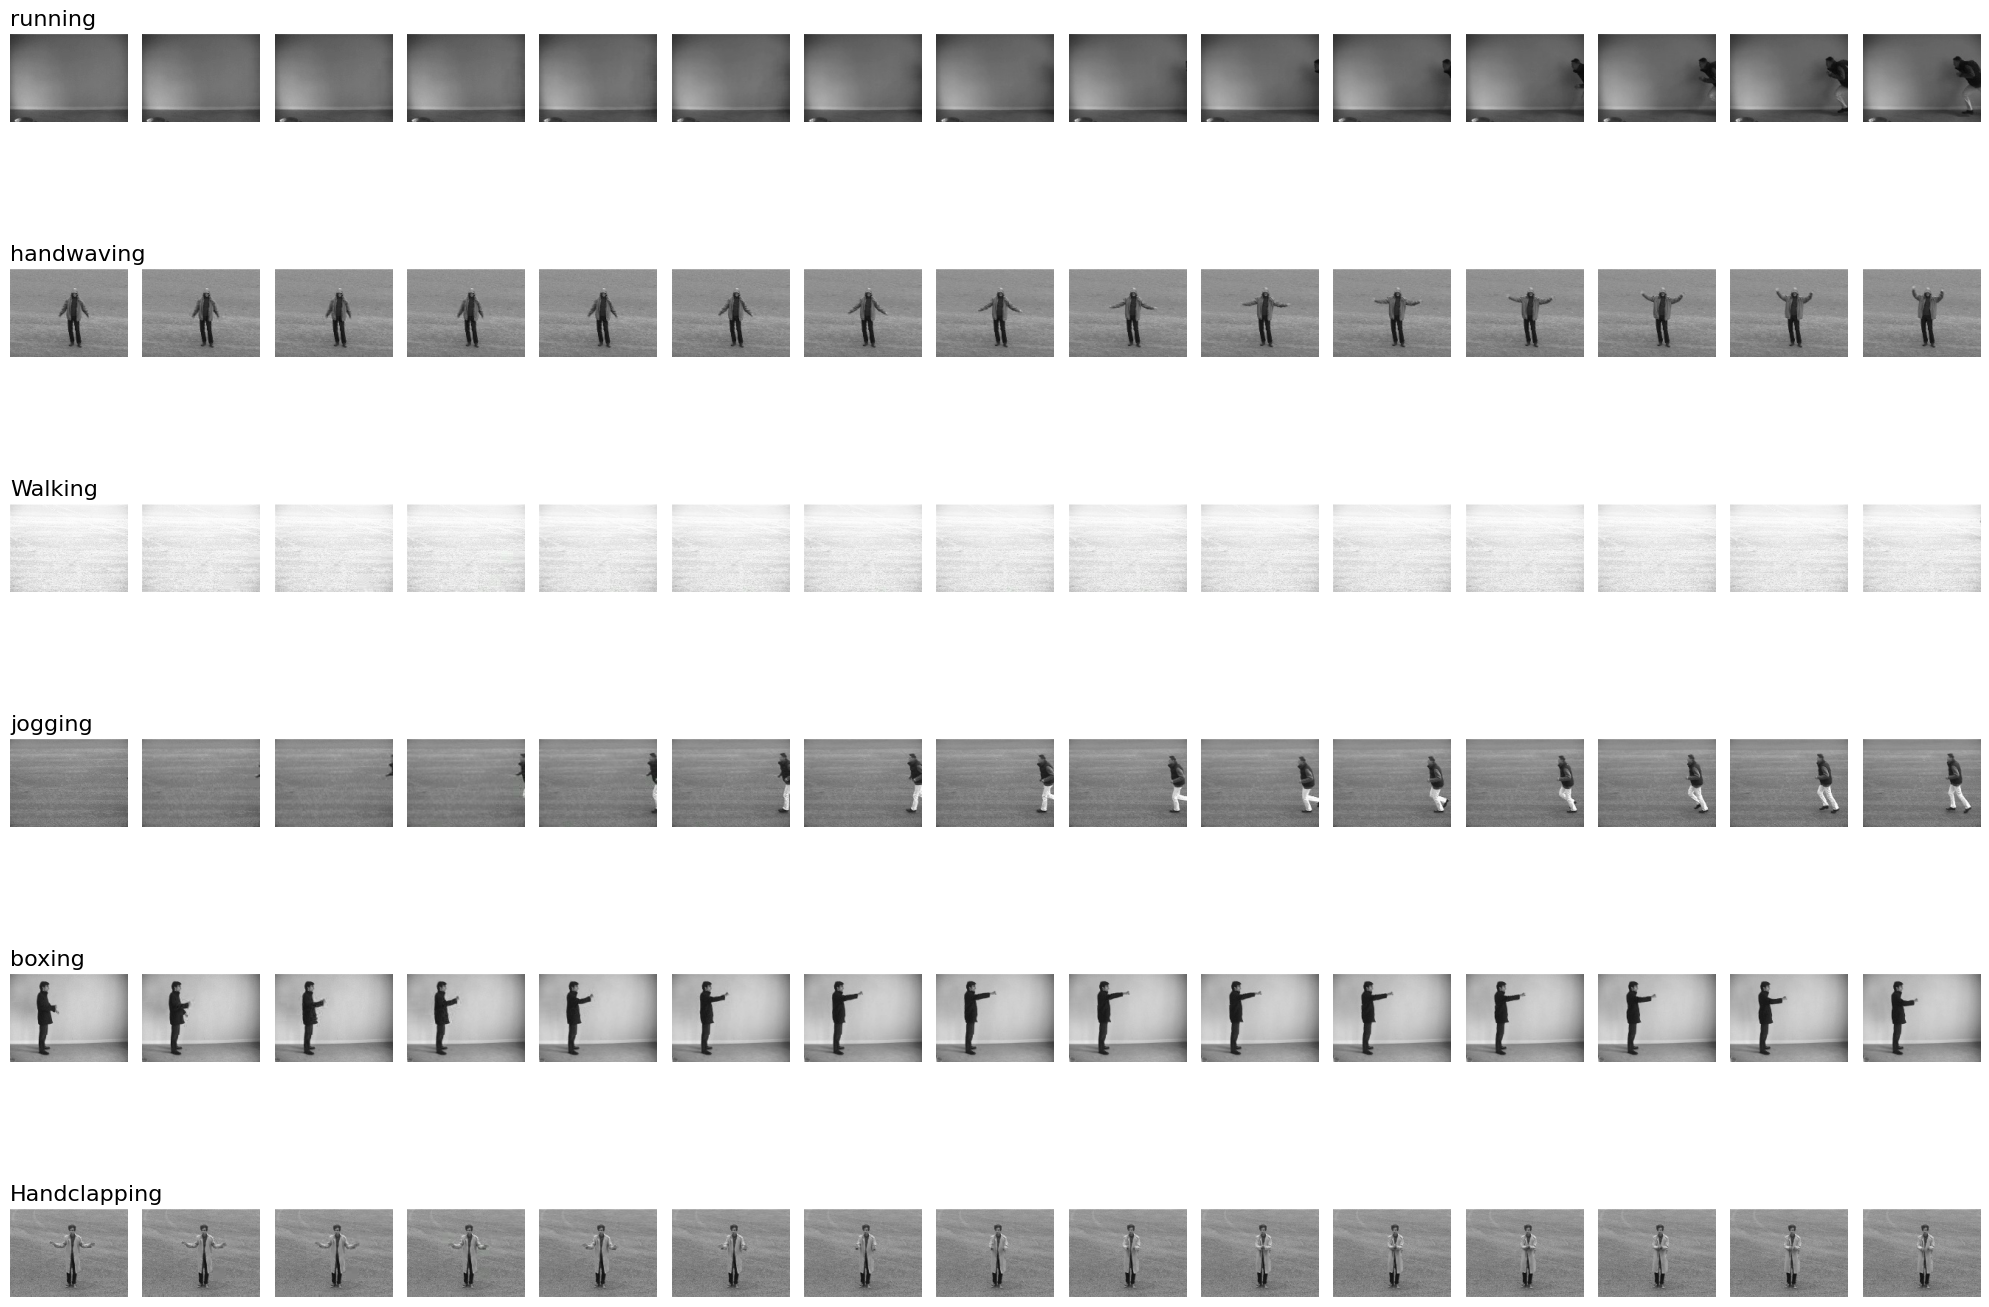

In [26]:
input_folder = "preprocessed_videos/train"
visualize_classes(input_folder=input_folder, num_frames_per_class=15)


### Create the Neural Network (4 points)

We can build the model in several ways. We can use a well-known model that we inject in time distributed layer, or we can build our own.

With custom ConvNet each input image of the sequence must pass to a convolutional network. The goal is to train that model for each frame and then decide the class to infer.

* Use ConvNet and Time distributed to detect features.
* Inject the Time distributed output to GRU or LSTM to treat as a time series.
* Apply a DenseNet to take the decision and classify.

##### Build the ConvNet for the feature extraction, GRU LSTM layers as a time series and Dense layers for classification

In [81]:
IMG_HEIGHT, IMG_WIDTH = 120, 160
NUM_CLASSES = 6
TRAIN_DATA_DIR = "preprocessed_videos/train"
TEST_DATA_DIR = "preprocessed_videos/test"
BATCH_SIZE = 5
TIME_STEPS = 20
EPOCHS = 10  # start with low EPOCHS like 5 and then increase based on the results.


In [82]:
def load_data(data_dir, img_height, img_width, num_classes, time_steps):
    X = []
    y = []
    class_labels = sorted(os.listdir(data_dir))
    # class_labels = os.listdir(data_dir)
    for label in class_labels:
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for video_folder in sorted(os.listdir(class_dir)):
                video_path = os.path.join(class_dir, video_folder)
                if os.path.isdir(video_path):
                    frames = []
                    for frame_file in sorted(os.listdir(video_path)):
                        frame_path = os.path.join(video_path, frame_file)
                        frame = cv.imread(frame_path)
                        frame = cv.resize(frame, (img_width, img_height))
                        frames.append(frame)
                    if len(frames) < time_steps:
                        frames.extend(
                            [np.zeros((img_height, img_width, 3))]
                            * (time_steps - len(frames))
                        )
                    X.append(frames)
                    y.append(class_labels.index(label) - 1)
    X = np.array(X)
    X = X / 255.0
    print(y)
    print(y[:10])
    y = to_categorical(y, num_classes)
    return X, y


In [83]:
# Check if the data files exist
X_train_file = "X_train.npy"
y_train_file = "y_train.npy"

if os.path.exists(X_train_file) and os.path.exists(y_train_file):
    # Load the data from .npy files
    X_train = np.load(X_train_file)
    y_train = np.load(y_train_file)
else:
    X_train, y_train = load_data(
        data_dir=TRAIN_DATA_DIR,
        img_height=IMG_HEIGHT,
        img_width=IMG_WIDTH,
        num_classes=NUM_CLASSES,
        time_steps=TIME_STEPS,
    )
    # Save the data to .npy files
    np.save(X_train_file, X_train)
    np.save(y_train_file, y_train)


In [84]:
X_test_file = "X_test.npy"
y_test_file = "y_test.npy"

if os.path.exists(X_test_file) and os.path.exists(y_test_file):
    # Load the data from .npy files
    X_test = np.load(X_test_file)
    y_test = np.load(y_test_file)
else:
    X_test, y_test = load_data(
        data_dir=TEST_DATA_DIR,
        img_height=IMG_HEIGHT,
        img_width=IMG_WIDTH,
        num_classes=NUM_CLASSES,
        time_steps=TIME_STEPS,
    )
    # Save the data to .npy files
    np.save(X_test_file, X_test)
    np.save(y_test_file, y_test)


In [85]:
# Split training data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=42
# )


In [86]:
X_val_file = "X_val.npy"
y_val_file = "y_val.npy"

if os.path.exists(X_val_file) and os.path.exists(y_val_file):
    # Load the data from .npy files
    X_val = np.load(X_val_file)
    y_val = np.load(y_val_file)
else:
    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    np.save(X_train_file, X_train)
    np.save(y_train_file, y_train)
    np.save(X_val_file, X_val)
    np.save(y_val_file, y_val)


In [87]:
# YOUR CODE HERE


def build_model(input_shape, num_classes, use_gru=True):
    model = Sequential()

    # ConvNet for feature extraction
    model.add(
        TimeDistributed(Conv2D(32, (3, 3), activation="relu"), input_shape=input_shape)
    )
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation="relu")))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation="relu")))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    # GRU or LSTM layers for time series processing
    if use_gru:
        model.add(GRU(128, return_sequences=True))
        model.add(GRU(128))
    else:
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(128))

    # Dense layers for classification
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model


In [88]:
input_shape = (
    TIME_STEPS,
    IMG_HEIGHT,
    IMG_WIDTH,
    3,
)  # (time_steps, height, width, channels)
model = build_model(input_shape, NUM_CLASSES, use_gru=True)
model.summary()


/Users/rajiv-ranjan/Documents/github/rajiv-ranjan/cds-mini-projects/m3/mini-project-3/.venv/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_26             │ (None, 20, 118, 158,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 20, 59, 79, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, 20, 57, 77, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 20, 28, 38, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 20, 26, 36,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 20, 13, 18,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 20, 29952)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 20, 128)        │    11,551,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,761,094 (44.87 MB)

 Trainable params: 11,761,094 (44.87 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
def train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    batch_size=32,
    epochs=50,
    checkpoint_path="best_model.h5",
):
    # Define callbacks
    callbacks = [
        ModelCheckpoint(
            checkpoint_path,
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
            verbose=1,
        ),
        EarlyStopping(
            monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1
        ),
        ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
        ),
    ]

    # Train model
    # history = model.fit(
    #     train_gen,
    #     steps_per_epoch=train_steps,
    #     validation_data=val_gen,
    #     validation_steps=val_steps,
    #     epochs=epochs,
    #     callbacks=callbacks
    # )
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
    )

    return history


In [90]:
# Train the model
history = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    checkpoint_path="best_video_classifier.h5",
)


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1944 - loss: 1.9810
Epoch 1: val_accuracy improved from -inf to 0.13542, saving model to best_video_classifier.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.1946 - loss: 1.9802 - val_accuracy: 0.1354 - val_loss: 1.8231 - learning_rate: 0.0010
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1663 - loss: 1.8334
Epoch 2: val_accuracy did not improve from 0.13542
77/77 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.1661 - loss: 1.8332 - val_accuracy: 0.1354 - val_loss: 1.7987 - learning_rate: 0.0010
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1431 - loss: 1.8061
Epoch 3: val_accuracy did not improve from 0.13542
77/77 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.1433 - loss: 1.8061 - val_accuracy: 0.1250 - val_loss: 1.8255 - learning_rate: 0.0010
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1738 - loss: 1.7975
Epoch 4: val_accuracy did not improve from 0.13542
77/77 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.1737 - loss: 1.7974 - val_accuracy: 0.1354 - val_loss: 1.7942 - learning_rate: 0.0010
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 

In [91]:
def plot_training_history(history):
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    plt.tight_layout()
    plt.show()


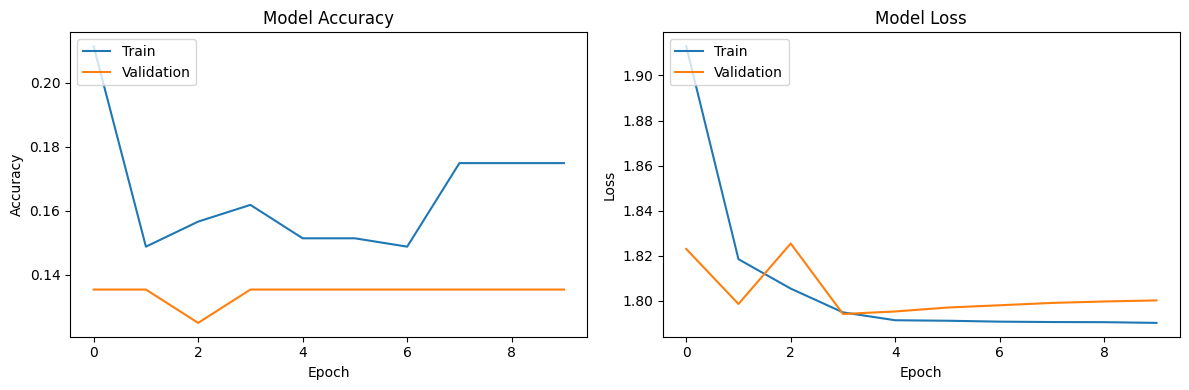

In [92]:
# Plot training history
plot_training_history(history)


In [93]:
model.save("video_classification.h5")


#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [94]:
# Note: There will be a high memory requirement for the training steps below.
# You should work on a GPU/TPU based runtime. See 'Change Runtime' in Colab
# Training time for each epoch could be ~30 mins
# To save and re-load your model later, see the reference below:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb

# YOUR CODE HERE


### Use pre-trained model for feature extraction (3 points)

To create a deep learning network for video classification:

* Convert videos to sequences of feature vectors using a pretrained convolutional neural network, such as VGG16, to extract features from each frame.

* Train an LSTM network on the sequences to predict the video labels.

* Assemble a network that classifies videos directly by combining layers from both networks.

Hint: [VGG-16 CNN and LSTM](https://riptutorial.com/keras/example/29812/vgg-16-cnn-and-lstm-for-video-classification)

#### Load and fine-tune the pre-trained model

In [95]:
# YOUR CODE HERE
def extract_features(videos, model):
    frames_features = []
    for video in videos:
        video_features = []
        for frame in video:
            # Preprocess the frame for VGG16
            frame = np.expand_dims(frame, axis=0)
            frame = keras.applications.vgg16.preprocess_input(frame)
            features = model.predict(frame)
            video_features.append(features)
        frames_features.append(np.array(video_features))
    return np.array(frames_features)


In [96]:
# Sample
# keras.applications.VGG16(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
#     name="vgg16",
# )


vgg16_base = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(120, 160, 3),
    pooling="avg",
    classes=6,
    classifier_activation="softmax",
    name="vgg16",
)
vgg16_base.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 120, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 120, 160, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 120, 160, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 60, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 60, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 60, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 30, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 30, 40, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 30, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 30, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 15, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 15, 20, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 15, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 15, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 7, 10, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 7, 10, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 7, 10, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 7, 10, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
video_input = Input(shape=(TIME_STEPS, 120, 160, 3))
x = TimeDistributed(vgg16_base)(video_input)
x = TimeDistributed(Flatten())(x)
# x = LSTM(128, return_sequences=True)(x)
x = LSTM(128, return_sequences=False, dropout=0.3)(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(6, activation="softmax")(x)

model = Model(inputs=video_input, outputs=output)

# model.compile(
#     optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
# )
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 20, 120, 160,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 20, 512)        │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 20, 512)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,060,166 (57.45 MB)

 Trainable params: 15,060,166 (57.45 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# history = model.fit(
#     X_train, y_train, epochs=10, batch_size=8, validation_data=(X_val, y_val)
# )
history = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    checkpoint_path="best_video_classifier_from_vgg16.h5",
)


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1440 - loss: 1.9398
Epoch 1: val_accuracy improved from -inf to 0.23958, saving model to best_video_classifier_from_vgg16.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 568s 7s/step - accuracy: 0.1441 - loss: 1.9397 - val_accuracy: 0.2396 - val_loss: 1.7920 - learning_rate: 0.0010
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1841 - loss: 1.8963
Epoch 2: val_accuracy did not improve from 0.23958
77/77 ━━━━━━━━━━━━━━━━━━━━ 558s 7s/step - accuracy: 0.1841 - loss: 1.8963 - val_accuracy: 0.1458 - val_loss: 1.8017 - learning_rate: 0.0010
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1602 - loss: 1.8926
Epoch 3: val_accuracy did not improve from 0.23958
77/77 ━━━━━━━━━━━━━━━━━━━━ 558s 7s/step - accuracy: 0.1600 - loss: 1.8926 - val_accuracy: 0.1458 - val_loss: 1.8063 - learning_rate: 0.0010
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1537 - loss: 1.8574
Epoch 4: val_accuracy did not improve from 0.23958
77/77 ━━━━━━━━━━━━━━━━━━━━ 559s 7s/step - accuracy: 0.1538 - loss: 1.8573 - val_accuracy: 0.2396 - val_loss: 1.7969 - learning_rate: 0.0010
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 

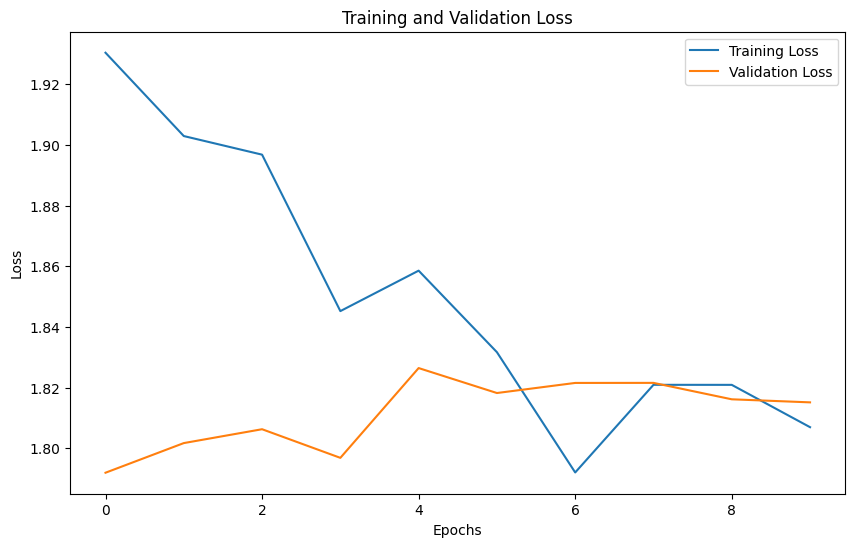

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [100]:
# YOUR CODE HERE
model_path = "video_classification.h5"
model = load_model(model_path)

for layer in model.layers[:-4]:
    layer.trainable = False

x = model.output
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
new_output = Dense(6, activation="softmax")(x)

new_model = Model(inputs=model.input, outputs=new_output)

new_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

new_model.summary()


AttributeError: The layer sequential_1 has never been called and thus has no defined output.

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

In [ ]:
# YOUR CODE HERE
history = new_model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_val, y_val))


In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


### Report Analysis

* Discuss on FPS, Number of frames and duration of each video
* Analyze the impact of the LSTM, GRU and TimeDistributed layers
* Discuss about the model convergence using pre-trained and ConvNet
* *Additional Reading*: Read and discuss about the use of Conv3D in video classification